In [1]:
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.cluster import HDBSCAN

from util.constants import (
    INCIDENT_CATS_MISC,
    INCIDENT_CATS_NARCOTICS,
    INCIDENT_CATS_SEX_ASSAULT_GENDER,
    INCIDENT_CATS_VIOLENCE,
)
from util.general import list_to_parsed_set

In [38]:
# Boundaries
chi_communities = gp.read_file("data/chicago_comm_utm/chicago_comm_utm.shp")[
    ["NID", "geometry"]
]
chi_streets = gp.read_file(
    "data/chi_street_lines/geo_export_df3e19c4-8a1b-41de-be21-1d0b821afcfb.shp"
)
hexbin_bounding_box = gp.read_file("data/hexbin_bounding_box.geojson")
_x_min, _y_min, _x_max, _y_max = hexbin_bounding_box.total_bounds
ucpd_patrol_area = gp.read_file("data/UCPD_patrol_area.geojson")

# Constants
CATEGORY_INFO = "Information"
CLUSTER_KEY = "hdb_cluster"
ESPG_NUM = 4326
FIGURE_SIZE = (25, 25)
HEXBIN_VIEWPORT_X = (_x_min, _x_max)
HEXBIN_VIEWPORT_Y = (_y_min, _y_max)
VIEWPORT_X = (-87.615, -87.57)
VIEWPORT_Y = (41.775, 41.83)

# Helper Functions


def contains_violence(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in INCIDENT_CATS_VIOLENCE:
            return True
    return False


def contains_sa_gb(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in INCIDENT_CATS_SEX_ASSAULT_GENDER:
            return True
    return False


def contains_narcotics(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in INCIDENT_CATS_NARCOTICS:
            return True
    return False


def hdbscan_hexbin_plotting(df: gp.GeoDataFrame, title_suffix: str) -> None:
    point_array = np.array(
        [
            (point.y, point.x)
            for point in df.to_crs(crs=f"EPSG:{ESPG_NUM}").geometry
        ]
    )

    min_cluster_size = max(int(df.shape[0] * 0.05), 5)

    hdb = HDBSCAN(min_cluster_size=min_cluster_size).fit(point_array)
    hdb_labels = np.array(hdb.labels_)

    # Filter out noise points (label -1 indicates noise in HDBSCAN)
    clustered_points = point_array[hdb_labels != -1]

    # Number of clusters and noise points
    n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
    n_noise = list(hdb_labels).count(-1)

    print(f"{title_suffix} Summary Statistics")
    print(f"Estimated number of clusters: {n_clusters}")
    print(
        f"Estimated number of clustered points: {clustered_points.shape[0]}/{point_array.shape[0]}"
    )
    print(f"Estimated number of noise points: {n_noise}/{point_array.shape[0]}")

    hdb_fig, hdb_ax = plt.subplots(figsize=FIGURE_SIZE)
    chi_communities.to_crs(epsg=ESPG_NUM).plot(
        ax=hdb_ax, color="none", edgecolor="black"
    )
    chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=hdb_ax, color="grey")

    ucpd_patrol_area.to_crs(epsg=ESPG_NUM).plot(
        ax=hdb_ax, color="maroon", linewidth=3.5
    )

    min_cnt = max(2, clustered_points.shape[0] // 100)
    print(f"Estimated minimum points per hex: {min_cnt}")
    # Create hexbin plot
    h = hdb_ax.hexbin(
        clustered_points[:, 1],
        clustered_points[:, 0],
        gridsize=50,
        cmap="YlOrRd",
        edgecolors="black",
        extent=[
            HEXBIN_VIEWPORT_X[0],
            HEXBIN_VIEWPORT_X[1],
            HEXBIN_VIEWPORT_Y[0],
            HEXBIN_VIEWPORT_Y[1],
        ],
        mincnt=min_cnt,
    )

    # Adding color bar
    cb = hdb_fig.colorbar(h, ax=hdb_ax)
    cb.set_label("Number of Reported Incidents")

    hdb_ax.set_xlim(*VIEWPORT_X)
    hdb_ax.set_ylim(*VIEWPORT_Y)
    plt.title(
        f"Binning of {title_suffix.title().replace('And', 'and')}",
        fontsize=25,
    )
    plt.savefig(f"{title_suffix.replace(' ', '-')}.png")


def create_four_seasons_png(
    i_dict: {str: gp.GeoDataFrame}, category: str
) -> None:
    q_fig, q_ax = plt.subplots(2, 2, figsize=FIGURE_SIZE)

    q_fig.subplots_adjust(top=0.94)
    # Add standard layers to all graphs
    for qx in q_ax.flat:
        chi_communities.to_crs(epsg=ESPG_NUM).plot(
            ax=qx, color="none", edgecolor="black", zorder=1
        )
        chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=qx, color="grey", zorder=2)
        ucpd_patrol_area.to_crs(epsg=ESPG_NUM).plot(
            ax=qx,
            color="maroon",
            linewidth=3.5,
            zorder=3,
        )
        qx.set_xlim(*VIEWPORT_X)
        qx.set_ylim(*VIEWPORT_Y)

    # Spring Image
    spring_df = i_dict["Spring"][i_dict["Spring"].hdb_cluster != "-1"]
    i_dict["Spring"].plot(
        ax=q_ax[0, 0], markersize=5, color="darkgrey", zorder=3
    )
    spring_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[0, 0],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[0, 0].set_title(f"HDBSCAN Clusters for {category} Crimes: Spring")

    # Summer Image
    summer_df = i_dict["Summer"][i_dict["Summer"].hdb_cluster != "-1"]
    i_dict["Summer"].plot(
        ax=q_ax[0, 1], markersize=5, color="darkgrey", zorder=3
    )
    summer_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[0, 1],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[0, 1].set_title(f"HDBSCAN Clusters for {category} Crimes: Summer")

    # Fall Image
    fall_df = i_dict["Fall"][i_dict["Fall"].hdb_cluster != "-1"]
    i_dict["Fall"].plot(ax=q_ax[1, 0], markersize=5, color="darkgrey", zorder=3)
    fall_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[1, 0],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[1, 0].set_title(f"HDBSCAN Clusters for {category} Crimes: Fall")

    # Winter Image
    winter_df = i_dict["Winter"][i_dict["Winter"].hdb_cluster != "-1"]
    i_dict["Winter"].plot(
        ax=q_ax[1, 1], markersize=5, color="darkgrey", zorder=3
    )
    winter_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[1, 1],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[1, 1].set_title(f"HDBSCAN Clusters for {category} Crimes: Winter")

    q_fig.suptitle(f"Seasonal HDBSCANs for {category} Crimes", fontsize=25)

    plt.savefig(f"{category.lower()}-seasons.png")


def polars_dicts_to_geopandas(
    pl_dict: {str: pl.DataFrame},
) -> {str: gp.GeoDataFrame}:
    gp_dict: {str: gp.GeoDataFrame} = {}
    for k in pl_dict.keys():
        gp_df = pl_dict[k].to_pandas()
        gp_df = gp.GeoDataFrame(
            gp_df,
            geometry=gp.points_from_xy(gp_df["longitude"], gp_df["latitude"]),
            crs=f"EPSG:{ESPG_NUM}",
        )
        gp_dict[k] = gp_df

    return gp_dict

In [39]:
all_df = pl.read_csv(
    "./data/incident_dump.csv",
).with_columns(
    pl.col("reported")
    .str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z")
    .dt.convert_time_zone("America/Chicago"),
    pl.col("reported_date").str.to_date("%Y-%m-%d"),
    pl.col("validated_location").str.split(",").cast(pl.List(pl.Float64)),
    pl.col("validated_location")
    .str.split(",")
    .cast(pl.List(pl.Float64))
    .apply(lambda v: v[1])
    .alias("longitude"),
    pl.col("validated_location")
    .str.split(",")
    .cast(pl.List(pl.Float64))
    .apply(lambda v: v[0])
    .alias("latitude"),
)
all_df = all_df.filter(~pl.col("validated_address").is_null()).filter(
    pl.col("incident") != CATEGORY_INFO
)

In [40]:
type_set = list_to_parsed_set(all_df["incident"].to_list())
type_set.remove(CATEGORY_INFO)

categorized_total = []
categorized_total.extend(INCIDENT_CATS_VIOLENCE)
categorized_total.extend(INCIDENT_CATS_SEX_ASSAULT_GENDER)
categorized_total.extend(INCIDENT_CATS_NARCOTICS)
categorized_total.extend(INCIDENT_CATS_MISC)

# To make sure that all values are categorized
print(f"Unique categories: {len(type_set)}")
print(
    f"Non-represented incident types: {type_set.difference(set(categorized_total))}"
)

Unique categories: 301
Non-represented incident types: set()


In [41]:
violence = {
    "All": all_df.filter(pl.col("incident").apply(contains_violence)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_violence)
    ),
}

sa_gb = {
    "All": all_df.filter(pl.col("incident").apply(contains_sa_gb)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
}

narcotics = {
    "All": all_df.filter(pl.col("incident").apply(contains_narcotics)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
}

violence = polars_dicts_to_geopandas(violence)
sa_gb = polars_dicts_to_geopandas(sa_gb)
narcotics = polars_dicts_to_geopandas(narcotics)

sexual assault and gender-based incidents: all seasons Summary Statistics
Estimated number of clusters: 8
Estimated number of clustered points: 283/513
Estimated number of noise points: 230/513
Estimated minimum points per hex: 2


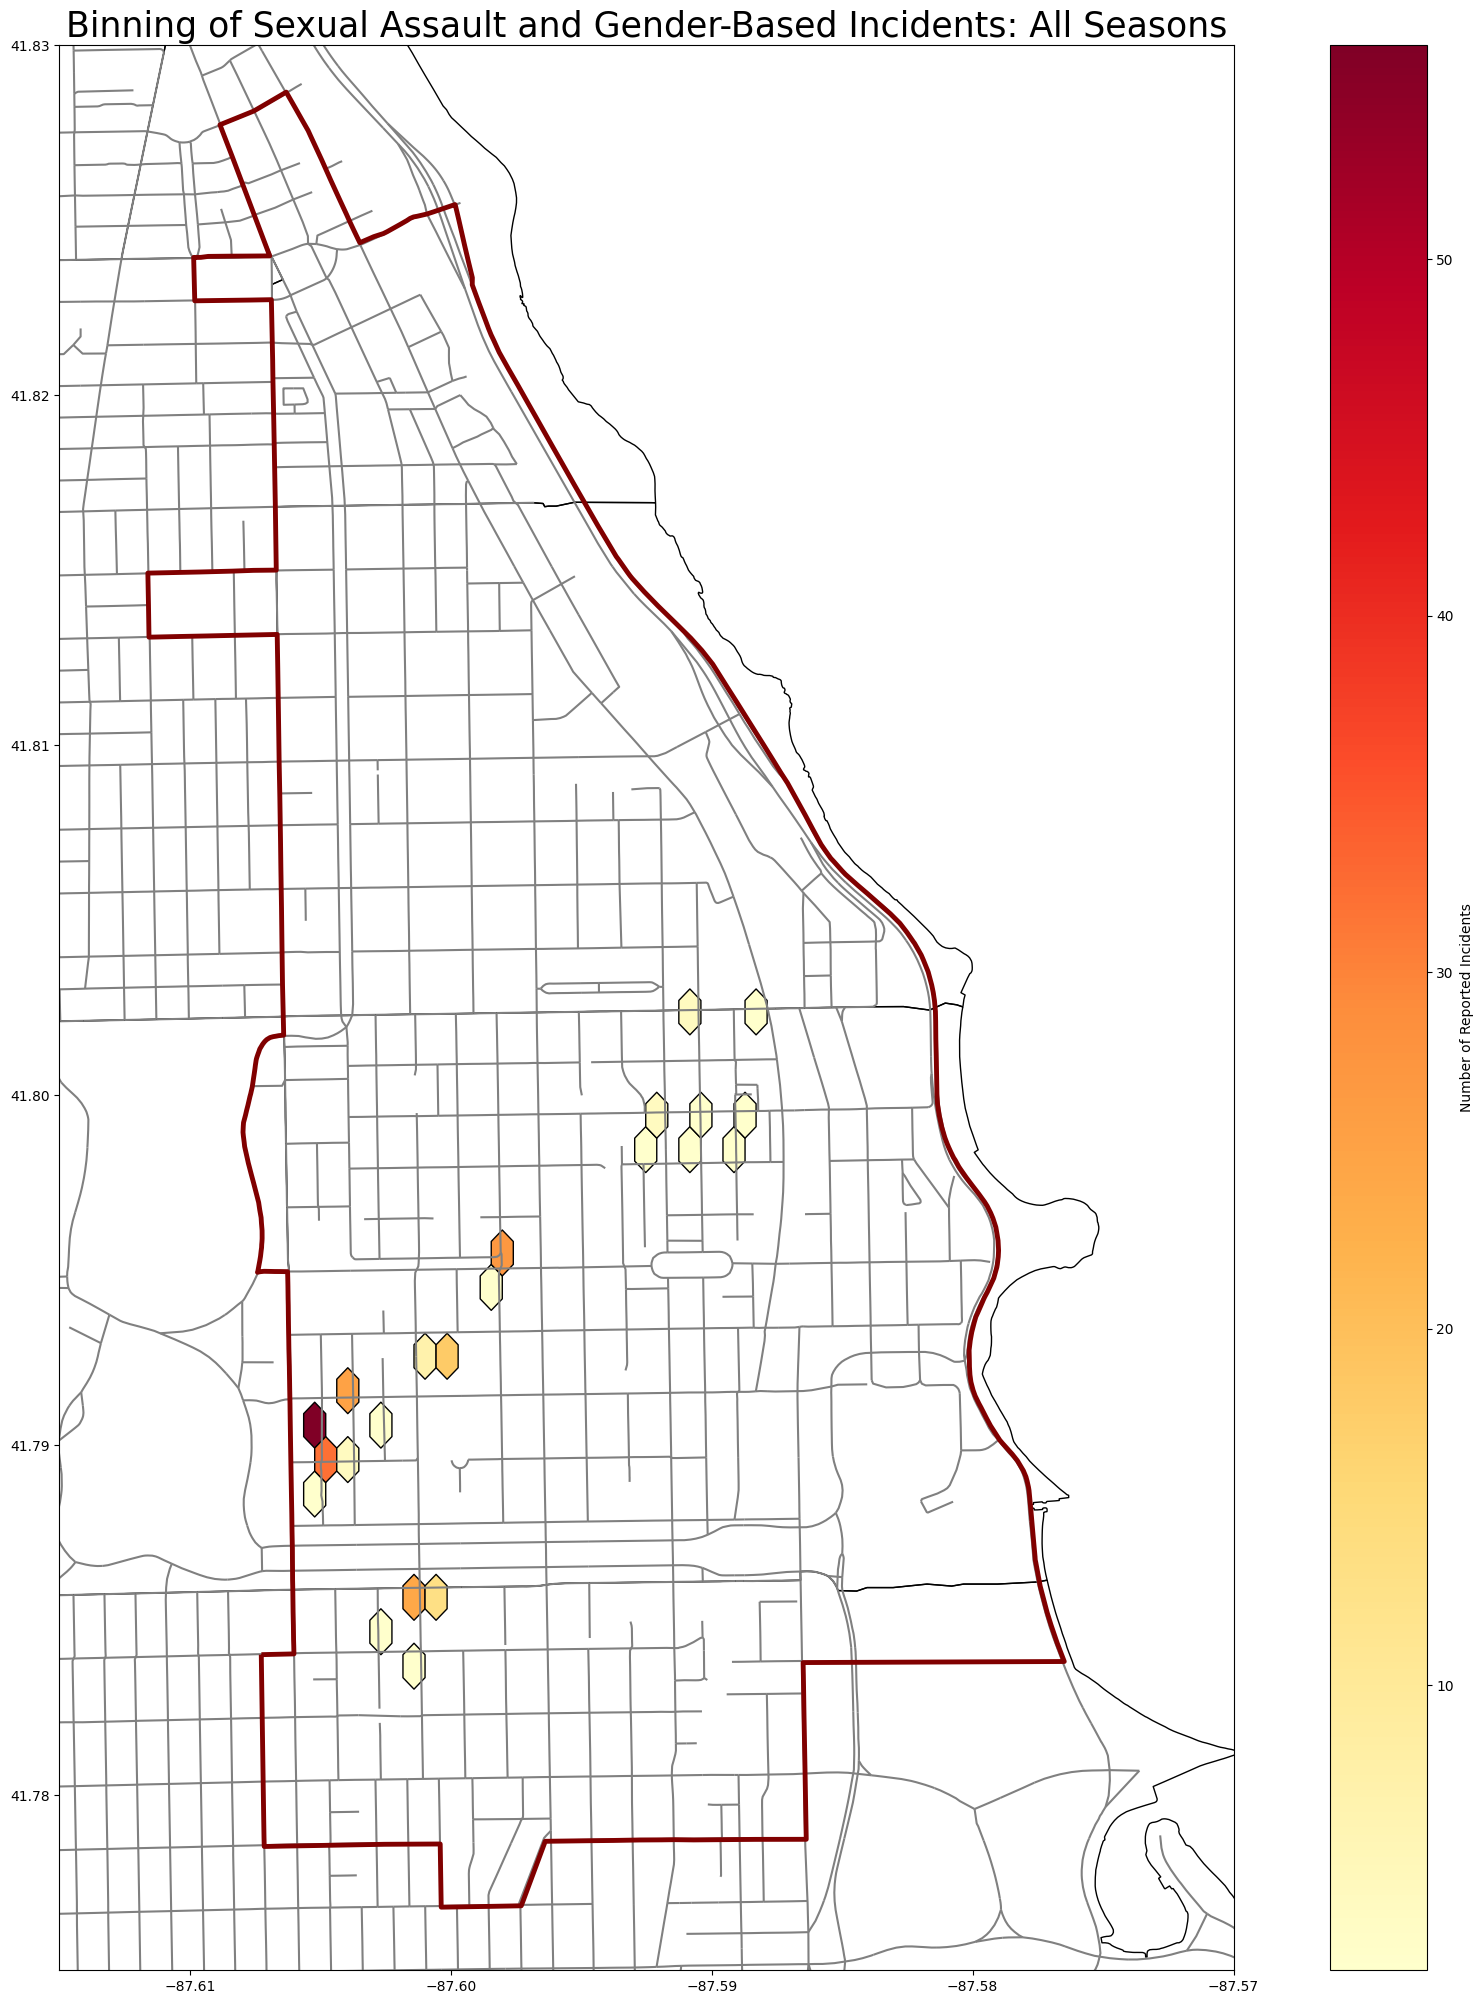

In [43]:
hdbscan_hexbin_plotting(
    sa_gb["All"], "sexual assault and gender-based incidents: all seasons"
)

violent incidents: all seasons Summary Statistics
Estimated number of clusters: 2
Estimated number of clustered points: 1040/2833
Estimated number of noise points: 1793/2833
Estimated minimum points per hex: 10


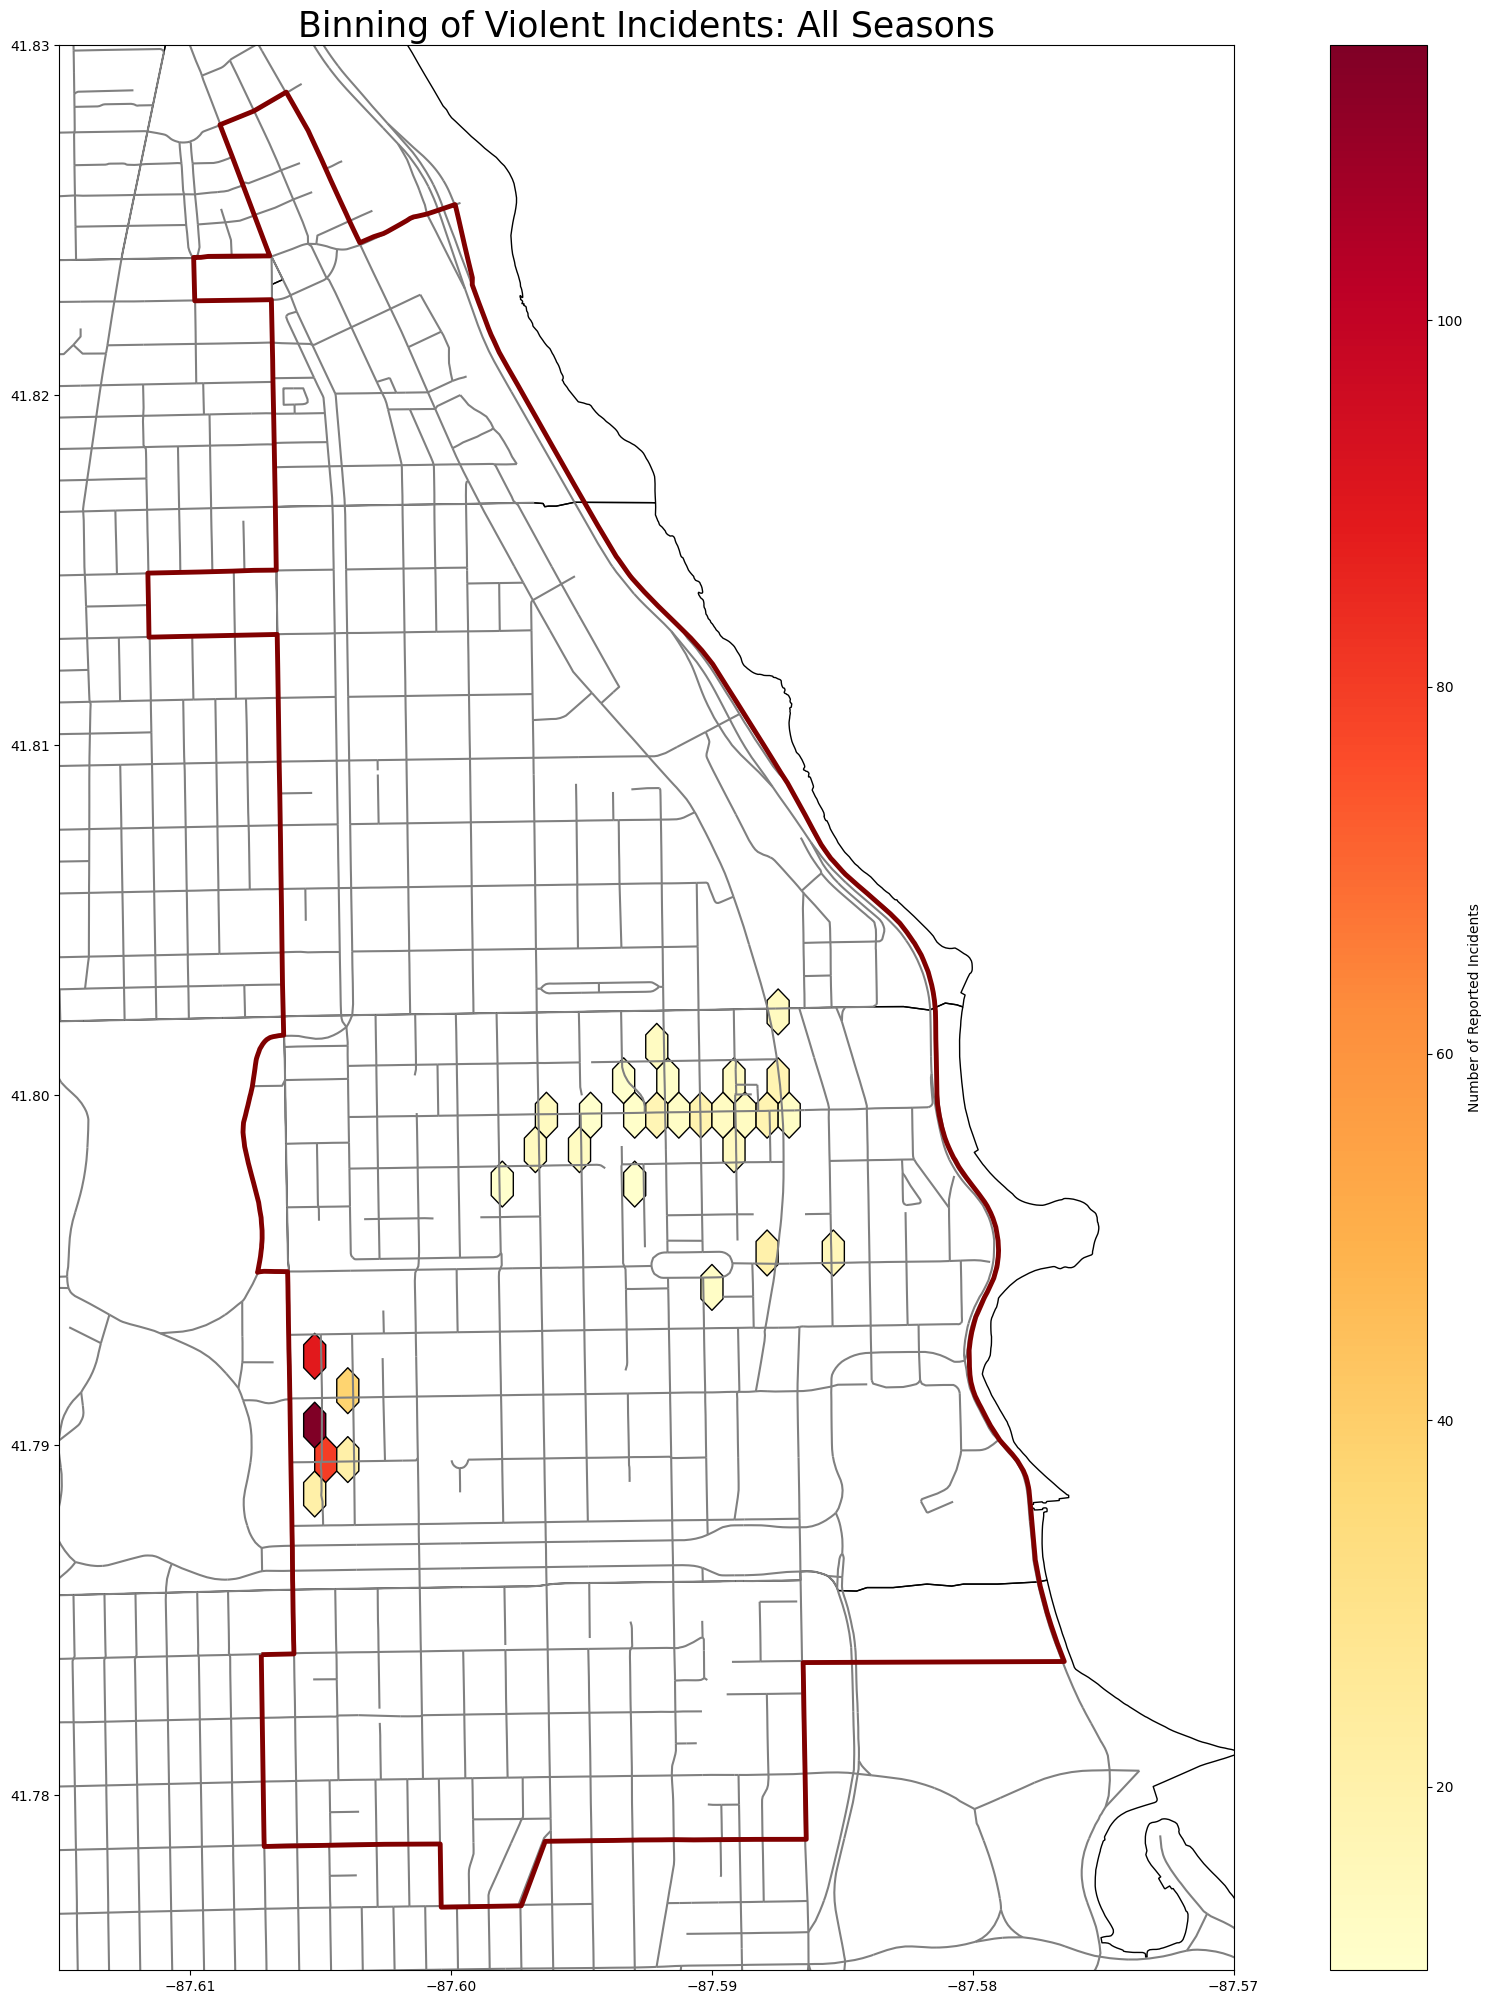

In [36]:
hdbscan_hexbin_plotting(violence["All"], "violent incidents: all seasons")

narcotic incidents: all seasons Summary Statistics
Estimated number of clusters: 4
Estimated number of clustered points: 239/344
Estimated number of noise points: 105/344
Estimated minimum points per hex: 2


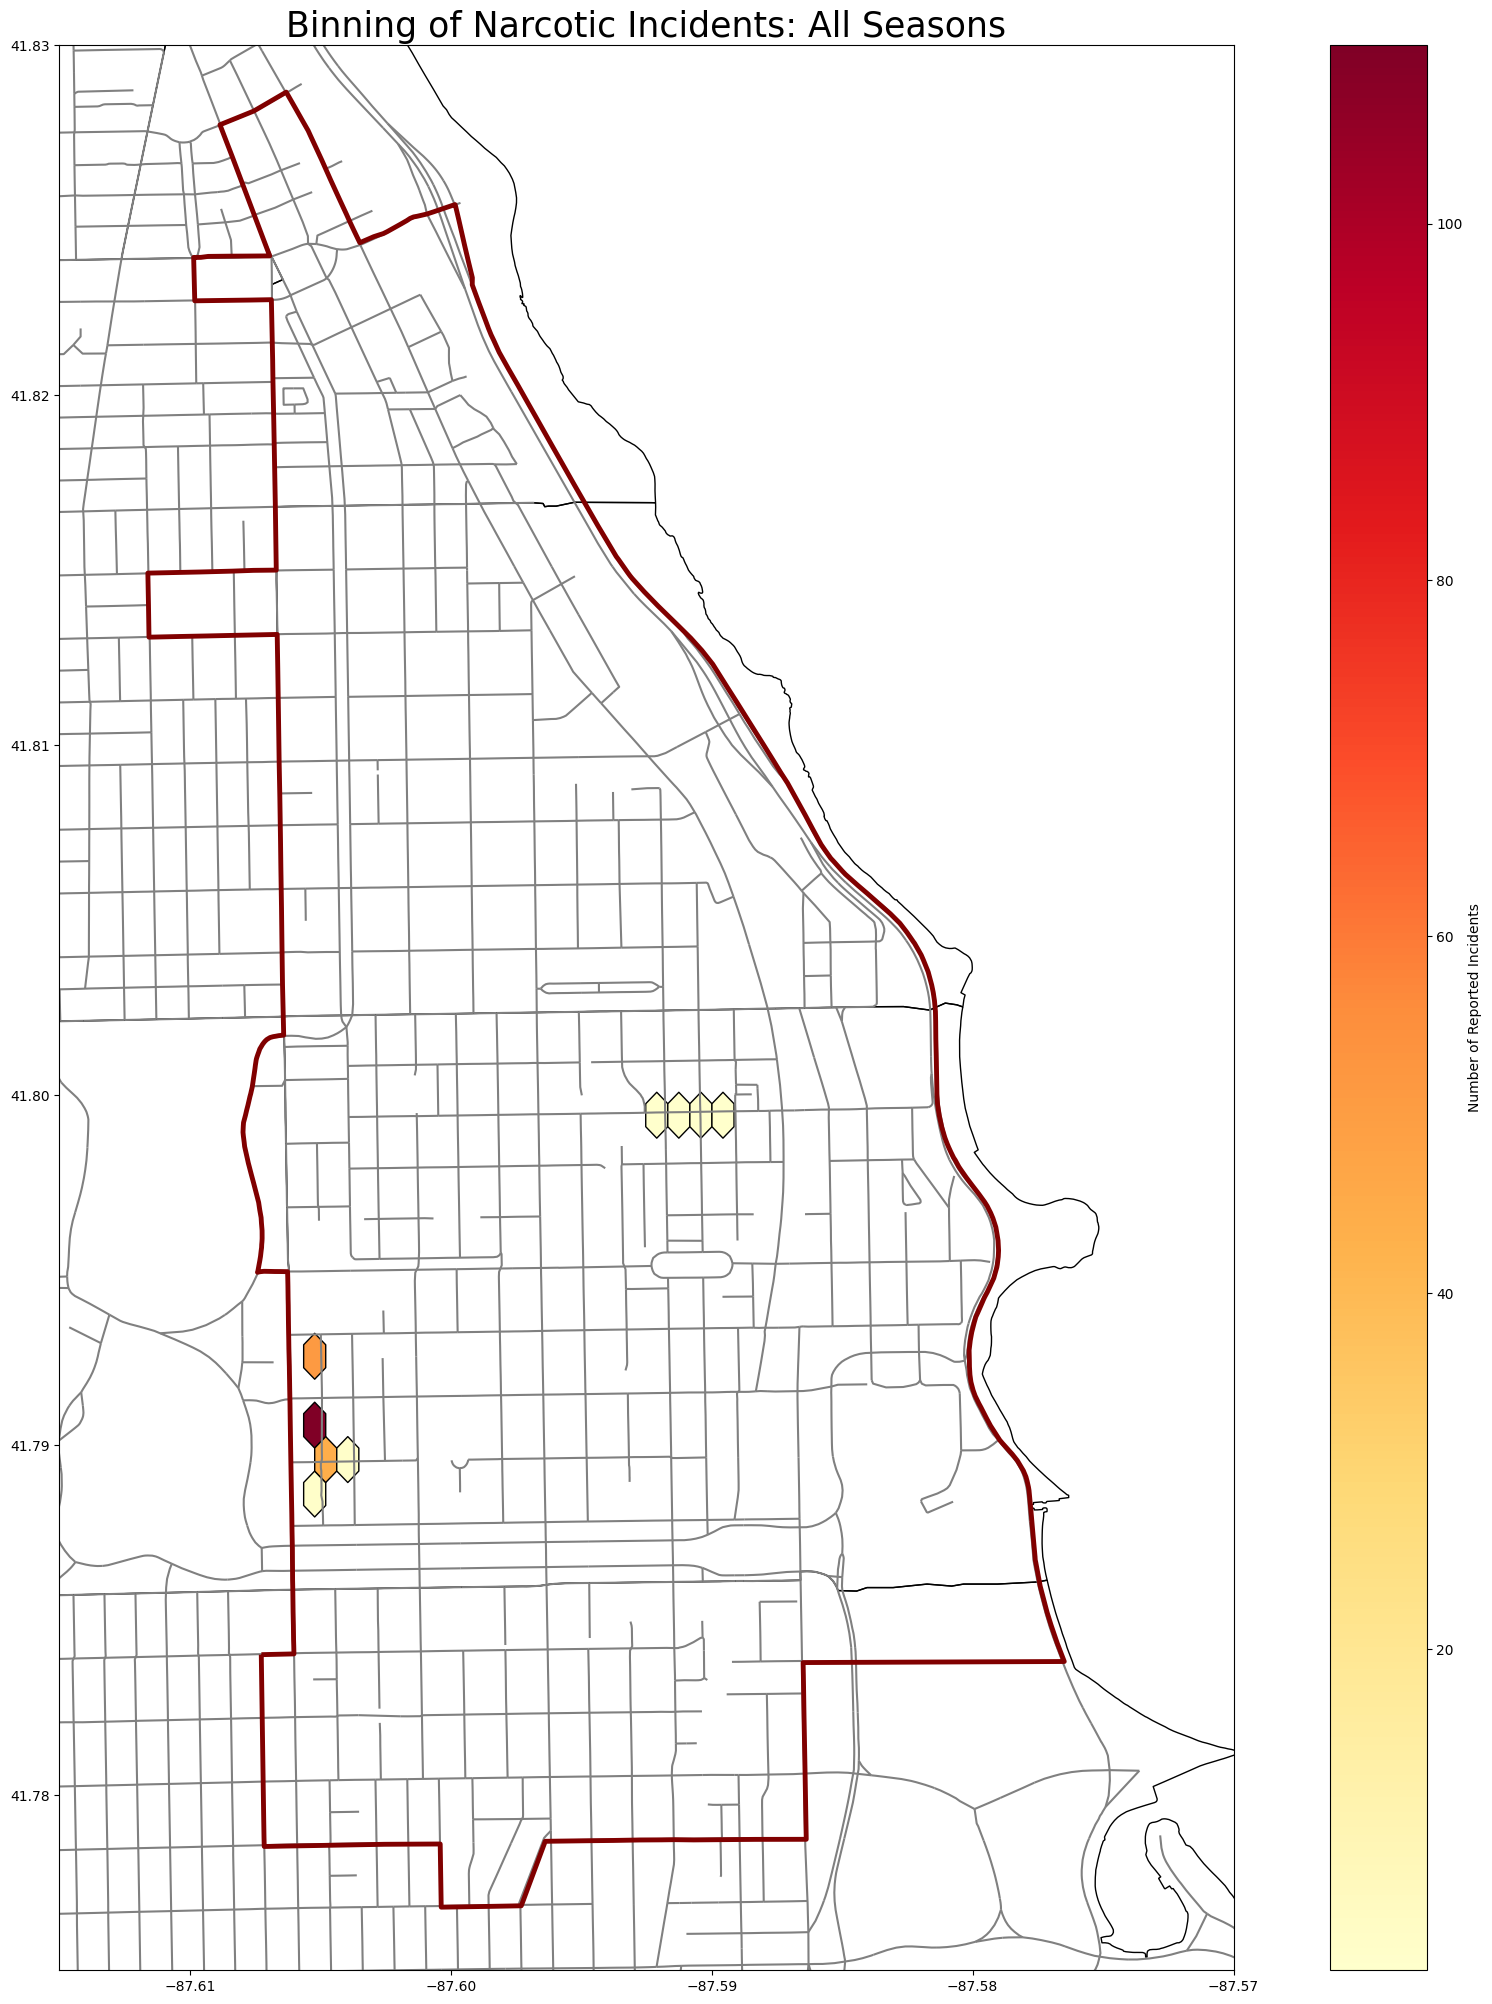

In [44]:
hdbscan_hexbin_plotting(narcotics["All"], "narcotic incidents: all seasons")

In [235]:
# create_four_seasons_png(violence, "Violent")

In [ ]:
# create_four_seasons_png(sa_gb, "Sexual Assault and Gender-based")

In [ ]:
# create_four_seasons_png(narcotics, "Narcotics-related")